# 1. Import necessary libraries

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt
from sklearn import metrics
import seaborn as sn
from sklearn.model_selection import train_test_split
import itertools
import time
import json
from tqdm import tqdm

# 2. Get the data
## 2.1. Download the data from tensorflow
(only need to do this once)

In [273]:
# Load the KMNIST dataset
base_url = "http://codh.rois.ac.jp/kmnist/dataset/kmnist/"
files = {
    "train_images": "kmnist-train-imgs.npz",
    "train_labels": "kmnist-train-labels.npz",
    "test_images": "kmnist-test-imgs.npz",
    "test_labels": "kmnist-test-labels.npz"
}

# Use tf.keras.utils.get_file to download each file
data_dir = tf.keras.utils.get_file("kmnist_data", origin=base_url + files["train_images"], extract=False)
train_images_source = np.load(data_dir)["arr_0"]

data_dir = tf.keras.utils.get_file("kmnist_labels", origin=base_url + files["train_labels"], extract=False)
train_labels_source = np.load(data_dir)["arr_0"]

data_dir = tf.keras.utils.get_file("kmnist_test", origin=base_url + files["test_images"], extract=False)
test_images_source = np.load(data_dir)["arr_0"]

data_dir = tf.keras.utils.get_file("kmnist_test_labels", origin=base_url + files["test_labels"], extract=False)
test_labels_source = np.load(data_dir)["arr_0"]

### 2.1.1 Split the training data into training and validation

In [274]:
# We will use 20% of the training data for validation (12k images)

train_images, validation_images, train_labels, validation_labels = train_test_split(train_images_source, train_labels_source, test_size= 0.2, random_state=42)

### 2.1.2 Check class balance after split

In [320]:
def plot_class_balance(train_labels, val_labels, title='Class Balance after train/validation split'):
    num_classes = max(train_labels.max(), val_labels.max()) + 1

    # Count class occurrences using np.bincount
    train_counts = np.bincount(train_labels, minlength=num_classes)
    val_counts = np.bincount(val_labels, minlength=num_classes)

    # Count occurrences and normalize to get relative frequencies
    train_counts = np.bincount(train_labels, minlength=num_classes)
    val_counts = np.bincount(val_labels, minlength=num_classes)

    train_freq = train_counts / train_counts.sum() * 100
    val_freq = val_counts / val_counts.sum() * 100

    x = np.arange(num_classes)
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width/2, train_freq, width, label='Train')
    ax.bar(x + width/2, val_freq, width, label='Validation')

    ax.set_xlabel('Class')
    ax.set_ylabel('Relative Frequency (%)')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(x)
    ax.legend()
    ax.set_ylim(0, max(train_freq.max(), val_freq.max()) * 1.2)
    ax.grid(False)

    plt.tight_layout()
    plt.show()

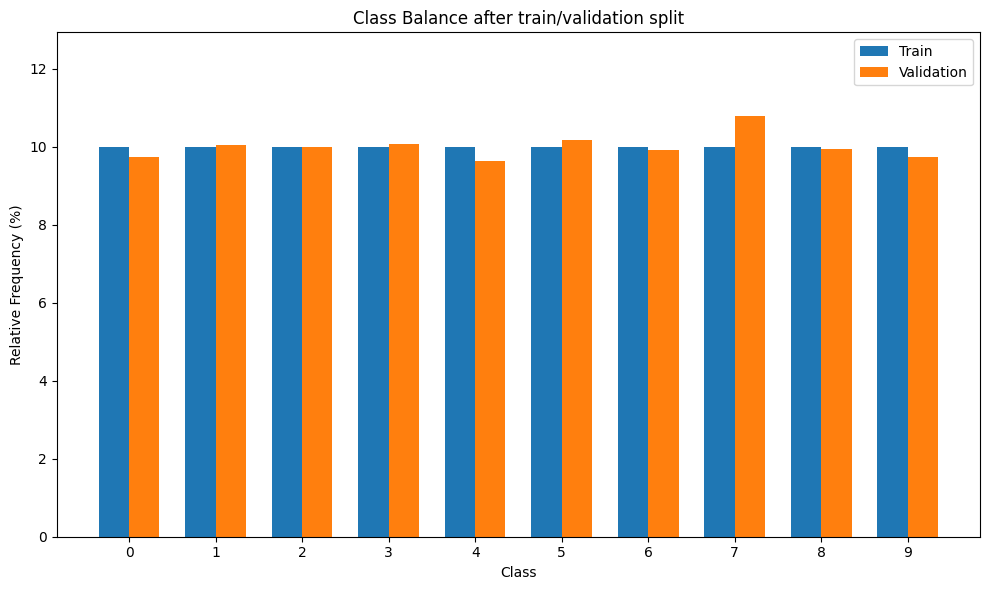

In [321]:
plot_class_balance(np.argmax(train_labels, axis=1), np.argmax(validation_labels, axis=1))

## 2.2. Save the data on the directory
(only need to do this once)

In [279]:
import os
# Save the data as .npz to prevent future download time

# create the correct folder
os.makedirs('data/train', exist_ok= True)
os.makedirs('data/validation', exist_ok= True)
os.makedirs('data/test', exist_ok= True)

# save the data separately between train and test
np.save('data/train/train_images.npy', train_images)
np.save('data/train/train_labels.npy', train_labels)
np.save('data/validation/validation_images.npy', validation_images)
np.save('data/validation/validation_labels.npy', validation_labels)
np.save('data/test/test_images.npy', test_images_source)
np.save('data/test/test_labels.npy', test_labels_source)

## 2.3 Load the data from the current directory
Use this to save time when returning to the project after leaving

In [4]:
# Load data

train_images = np.load('data/train/train_images.npy')
train_labels = np.load('data/train/train_labels.npy')
validation_images = np.load('data/validation/validation_images.npy')
validation_labels = np.load('data/validation/validation_labels.npy')
test_images = np.load('data/test/test_images.npy')
test_labels = np.load('data/test/test_labels.npy')

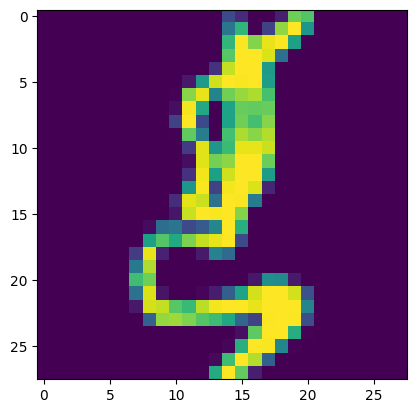

In [281]:
# Checking some of the instances in the training set

plt.imshow(train_images[11], interpolation = 'nearest')
plt.show()

## 2.4 Preprocessing
Data processing before model implementation

In [6]:
# Converting the train and validation labels to a numpy array with 10 lines (10 classes) to train the 10 output PE form the MLP

train_labels = pd.get_dummies(train_labels, dtype= int).to_numpy()
validation_labels = pd.get_dummies(validation_labels, dtype= int).to_numpy()

# Standardize the training, validation and test data

def numpy_normalize(X):
    X_norm = X / 255

    return X_norm

train_images_norm = np.array([numpy_normalize(image) for image in train_images])
validation_images_norm = np.array([numpy_normalize(image) for image in validation_images])
test_images_norm = np.array([numpy_normalize(image) for image in test_images])

# 3. Model definition
Section to define the models to use as python objects
## 3.1 MLP with 1 single hidden layer

In [112]:
# Class: MLP_1H (MLP with 1 hidden layer)
class MLP_1H:

  # Method: __init__
  def __init__(self, input_size, hidden_size, output_size, learning_rate):
      self.input_size = input_size
      self.hidden_size = hidden_size
      self.output_size = output_size

      self.sigma = 0.1
      self.miu = 0

      # Let's initialise the weights (and biases) between the inputs and the hidden layer
      self.weights_input_hidden = self.sigma * np.random.randn(self.input_size, self.hidden_size) + self.miu
      self.bias_hidden = np.zeros((1, self.hidden_size))

      # Let's initiliase the weights (and biases) between the hidden layer and the output layer
      self.weights_hidden_output = self.sigma * np.random.randn(self.hidden_size, self.output_size) + self.miu
      self.bias_output = np.zeros((1, self.output_size))

      self.learning_rate = learning_rate
      self.losses = list()
      self.val_losses = list()

      return


  # Method: Sigmoid
  def sigmoid(self, x):
      return 1 / (1 + np.exp(-x))


  # Method: Sigmoid derivative
  def sigmoid_derivative(self, x):
      return x * (1 - x)


  # Method: Forward pass
  def forward_pass(self, X):

    # Hidden layer output
    self.hidden_activation = np.dot(X, self.weights_input_hidden) + self.bias_hidden
    self.hidden_output = self.sigmoid(self.hidden_activation)

    # Output layer output
    self.output_activation = np.dot(self.hidden_output, self.weights_hidden_output) + self.bias_output
    self.predicted_output = self.sigmoid(self.output_activation)

    return self.predicted_output


  # Method: Backpropagation Algorithm
  def backpropagation_algorithm(self, X, y):

    # Step 1: Forward propagation
    y_pred = self.forward_pass(X)

    # Step 2: Compute the error
    err = y - y_pred
    # print(err)

    # Step 3: Backpropagate the errors (i.e., compute the deltas and the errors of the output(s) and hidden layer(s))
    # You will need to compute the derivative of the activation function of the neuron units (the activation function is a sigmoid)
    # Output delta (depends on the output error, err)
    output_delta = err * self.sigmoid_derivative(y_pred)
    # print(output_delta)

    # Then, we compute the errors related to the hidden layer, using the output delta (i.e., we know the magnitude of the error)
    hidden_error = np.dot(output_delta, self.weights_hidden_output.T)

    # We have to comput the delta to backpropagate to the weights of the input layer
    hidden_delta = hidden_error * self.sigmoid_derivative(self.hidden_output)

    # Step 4: Update the current weights using the notation weights_updated = weights - (derror_dweights * learning_rate)
    # As soon as you have all the errors and deltas, you can updated the weights and biases of your model
    # In this implementation, they use the delta rule
    # (+info: https://towardsdatascience.com/a-visual-explanation-of-gradient-descent-methods-momentum-adagrad-rmsprop-adam-f898b102325c/)

    # Update weights and biases of the weights between the hidden layer and the ouput
    self.weights_hidden_output += np.dot(self.hidden_output.T, output_delta) * self.learning_rate
    self.bias_output += np.sum(output_delta, axis=0, keepdims=True) * self.learning_rate

    # Update weights and biases of the weights between the input layer and the hidden layer
    self.weights_input_hidden += np.dot(X.T, hidden_delta) * self.learning_rate
    self.bias_hidden += np.sum(hidden_delta, axis=0, keepdims=True) * self.learning_rate

    return


  # Method: Train the MLP
  def train(self, X, y, epochs, X_val = None, y_val = None):
    self.epochs = epochs
    for epoch in range(epochs):
        output = self.forward_pass(X)
        self.backpropagation_algorithm(X, y)
        loss = np.mean(np.square(y - output))
        self.losses.append(loss)

        output_val = self.forward_pass(X_val)
        val_loss = np.mean(np.square(y_val - output_val))
        self.val_losses.append(val_loss)
        # print(f"Epoch {epoch}, Loss:{loss}")

### 3.1.1 MLP with 1 hidden layer created with tensorflow

In [10]:
def build_tf_model_1H(hidden_units, dropout, optimizer_name, lr):
    tf_MLP_1H = tf.keras.models.Sequential([
        tf.keras.Input(shape=(28, 28)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(hidden_units, activation= 'relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(10, activation= 'softmax')
    ])

    loss_fn = tf.losses.categorical_crossentropy

    if optimizer_name == 'sgd':
        optimizer_algorithm = tf.optimizers.SGD(learning_rate=lr)
    elif optimizer_name == 'adam':
        optimizer_algorithm = tf.optimizers.Adam(learning_rate=lr)
    else:
        raise ValueError("Unsupported optimizer")

    tf_MLP_1H.compile(optimizer = optimizer_algorithm,
                    loss = loss_fn,
                    metrics = ['accuracy',
                               tf.metrics.Precision(name='precision'),
                               tf.metrics.Recall(name='recall')])
    
    return tf_MLP_1H

## 3.2 MLP with 2 hidden layers

In [30]:
# Class: MLP_2H (MLP with 2 hidden layer)
class MLP_2H:

  # Method: __init__
  def __init__(self, input_size, hidden_size, hidden2_size, output_size, learning_rate):
      self.input_size = input_size
      self.hidden_size = hidden_size
      self.hidden2_size = hidden2_size
      self.output_size = output_size

      self.sigma = 0.1
      self.miu = 0
      # Let's initialise the weights (and biases) between the inputs and the first hidden layer
      self.weights_input_hidden = self.sigma * np.random.randn(self.input_size, self.hidden_size) + self.miu
      self.bias_hidden = np.zeros((1, self.hidden_size))

      # Let's initiliase the weights (and biases) between the first and second hidden layer
      self.weights_hidden_output = self.sigma * np.random.randn(self.hidden_size, self.hidden2_size) + self.miu
      self.bias_hidden2 = np.zeros((1, self.hidden2_size))

      # Let's initiliase the weights (and biases) between the second hidden layer and the output layer
      self.weights_hidden2_output = self.sigma * np.random.randn(self.hidden2_size, self.output_size) + self.miu
      self.bias_output = np.zeros((1, self.output_size))

      self.learning_rate = learning_rate
      self.losses = list()
      self.val_losses = list()

      return


  # Method: Sigmoid
  def sigmoid(self, x):
      return 1 / (1 + np.exp(-x))


  # Method: Sigmoid derivative
  def sigmoid_derivative(self, x):
      return x * (1 - x)


  # Method: Forward pass
  def forward_pass(self, X):

    # Hidden layer output
    self.hidden_activation = np.dot(X, self.weights_input_hidden) + self.bias_hidden
    self.hidden_output = self.sigmoid(self.hidden_activation)

    # Second Hidden layer output
    self.hidden2_activation = np.dot(self.hidden_output, self.weights_hidden_output) + self.bias_hidden2
    self.hidden2_output = self.sigmoid(self.hidden2_activation)

    # Output layer output
    self.output_activation = np.dot(self.hidden2_output, self.weights_hidden2_output) + self.bias_output
    self.predicted_output = self.sigmoid(self.output_activation)

    return self.predicted_output


  # Method: Backpropagation Algorithm
  def backpropagation_algorithm(self, X, y):

    # Step 1: Forward propagation
    y_pred = self.forward_pass(X)

    # Step 2: Compute the error
    err = y - y_pred

    # Step 3: Backpropagate the errors (i.e., compute the deltas and the errors of the output(s) and hidden layer(s))
    # You will need to compute the derivative of the activation function of the neuron units (the activation function is a sigmoid)
    # Output delta (depends on the output error, err)
    output_delta = err * self.sigmoid_derivative(y_pred)
    # print(output_delta)

    # Then, we compute the errors related to the hidden layer, using the output delta (i.e., we know the magnitude of the error)
    hidden2_error = np.dot(output_delta, self.weights_hidden2_output.T)

    # We have to comput the delta to backpropagate to the weights of the input layer
    hidden2_delta = hidden2_error * self.sigmoid_derivative(self.hidden2_output)

    # Then, we compute the errors related to the hidden layer, using the output delta (i.e., we know the magnitude of the error)
    hidden_error = np.dot(hidden2_delta, self.weights_hidden_output.T)

    # We have to comput the delta to backpropagate to the weights of the input layer
    hidden_delta = hidden_error * self.sigmoid_derivative(self.hidden_output)

    # Step 4: Update the current weights using the notation weights_updated = weights - (derror_dweights * learning_rate)
    # As soon as you have all the errors and deltas, you can updated the weights and biases of your model
    # In this implementation, they use the delta rule
    # (+info: https://towardsdatascience.com/a-visual-explanation-of-gradient-descent-methods-momentum-adagrad-rmsprop-adam-f898b102325c/)

    # Update weights and biases of the weights between the second hidden layer and the ouput
    
    self.weights_hidden2_output += np.dot(self.hidden2_output.T, output_delta) * self.learning_rate
    self.bias_output += np.sum(output_delta, axis=0, keepdims=True) * self.learning_rate

    # Update weights and biases of the weights between the two hidden layers
    
    self.weights_hidden_output += np.dot(self.hidden_output.T, hidden2_delta) * self.learning_rate
    self.bias_hidden2 += np.sum(hidden2_delta, axis=0, keepdims=True) * self.learning_rate

    # Update weights and biases of the weights between the input layer and the hidden layer
    self.weights_input_hidden += np.dot(X.T, hidden_delta) * self.learning_rate
    self.bias_hidden += np.sum(hidden_delta, axis=0, keepdims=True) * self.learning_rate

    return


  # Method: Train the MLP
  def train(self, X, y, epochs, X_val = None, y_val = None):
    self.epochs = epochs
    for epoch in range(epochs):
        output = self.forward_pass(X)
        self.backpropagation_algorithm(X, y)
        loss = np.mean(np.square(y - output))
        self.losses.append(loss)

        output_val = self.forward_pass(X_val)
        val_loss = np.mean(np.square(y_val - output_val))
        self.val_losses.append(val_loss)
        # print(f"Epoch {epoch}, Loss:{loss}")
        

    return

# 3.3 MLP with 3 hidden layers

In [9]:
def build_tf_model_3H(hidden_units1, hidden_units2, hidden_units3, dropout, optimizer_name, lr):
    tf_MLP_1H = tf.keras.models.Sequential([
        tf.keras.Input(shape=(28, 28)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(hidden_units1, activation= 'relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(hidden_units2, activation= 'relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(hidden_units3, activation= 'relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(10, activation= 'softmax')
    ])

    loss_fn = tf.losses.categorical_crossentropy

    if optimizer_name == 'sgd':
        optimizer_algorithm = tf.optimizers.SGD(learning_rate=lr)
    elif optimizer_name == 'adam':
        optimizer_algorithm = tf.optimizers.Adam(learning_rate=lr)
    else:
        raise ValueError("Unsupported optimizer")

    tf_MLP_1H.compile(optimizer = optimizer_algorithm,
                    loss = loss_fn,
                    metrics = ['accuracy',
                               tf.metrics.Precision(name='precision'),
                               tf.metrics.Recall(name='recall')])
    
    return tf_MLP_1H

# 4. Running the models

In [8]:
# Ploting accuracy and loss for both the training and validation sets

def plot_training_results(model_history):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(model_history.history['accuracy'], label='Train Accuracy', color='blue')
    if 'val_accuracy' in model_history.history:
        plt.plot(model_history.history['val_accuracy'], label='Val Accuracy', color='red')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(False)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(model_history.history['loss'], label='Train Loss', color='blue')
    if 'val_loss' in model_history.history:
        plt.plot(model_history.history['val_loss'], label='Val Loss', color='red')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(False)

    plt.tight_layout()
    plt.show()

## 4.1 MLP with 1 hidden layer

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3248 - loss: 2.0197 - val_accuracy: 0.6833 - val_loss: 1.2696
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 843us/step - accuracy: 0.6795 - loss: 1.1959 - val_accuracy: 0.7463 - val_loss: 0.9460
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 890us/step - accuracy: 0.7312 - loss: 0.9443 - val_accuracy: 0.7825 - val_loss: 0.8029
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 859us/step - accuracy: 0.7715 - loss: 0.8074 - val_accuracy: 0.8046 - val_loss: 0.7192
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 868us/step - accuracy: 0.7898 - loss: 0.7330 - val_accuracy: 0.8180 - val_loss: 0.6631
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 908us/step - accuracy: 0.8040 - loss: 0.6833 - val_accuracy: 0.8273 - val_loss: 0.6221
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 852us/step - accuracy: 0.8177 - loss: 0.6320 - val_accuracy: 0.8347 - val_loss: 0.5906
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 906us/step - accuracy: 0.

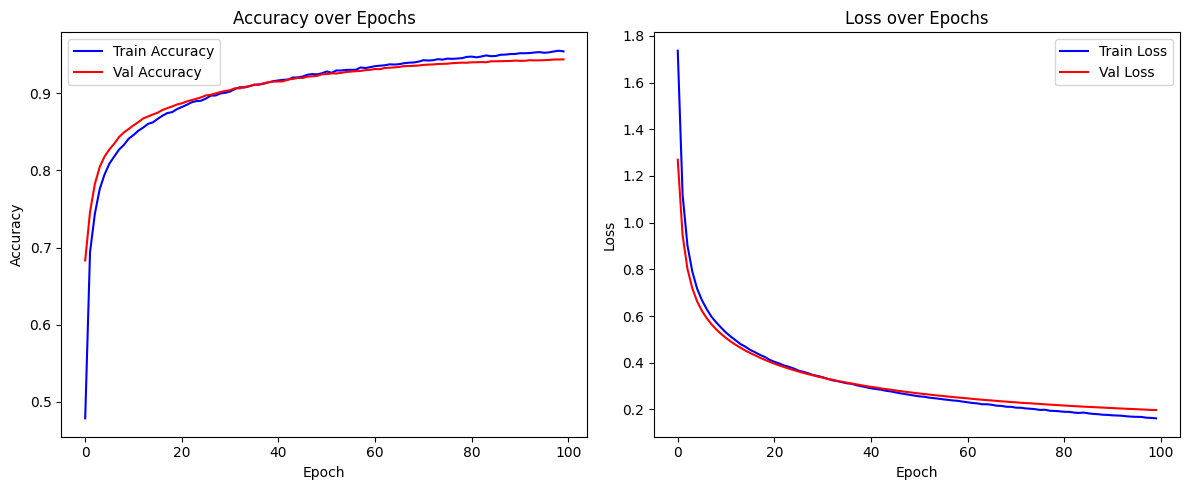

In [259]:
history = tf_MLP_1H.fit(train_images_norm, train_labels, epochs= 100, validation_split=0.2)

# Plot losses and accuracy
plot_training_results(history)

## 4.1.1 Conduct a grid search to fine tune some hyperparameters
Test multiple combinations of learning rate, dropout, hidden units and optimizers

In [286]:
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]
dropouts = [0.0, 0.2, 0.5]
hidden_neurons = [12, 64, 128, 256]
optimizers_list = ['sgd', 'adam']

# Grid search
results = []

# Ensure the file to save the models exists
os.makedirs("mlp1H_saved_models", exist_ok=True)

# Create the full grid of hyperparameters
grid = list(itertools.product(learning_rates, dropouts, hidden_neurons, optimizers_list))

start_time = time.time()

for lr, dr, hu, opt_name in tqdm(grid, desc="Grid Search Progress"):
    config_name = f"lr{lr}_do{dr}_hu{hu}_{opt_name}"
    model_path = f"saved_models/best_model_{config_name}.keras"

    print(f"Testing: {config_name}")

    model = build_tf_model_1H(hidden_units=hu, dropout=dr, optimizer_name=opt_name, lr=lr)

    # Save best model on validation accuracy
    checkpoint = ModelCheckpoint(
        filepath=model_path,
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        mode='max',
        verbose=0
    )

    history = model.fit(train_images_norm, train_labels, epochs=100, validation_data=(validation_images_norm, validation_labels), callbacks = [checkpoint], verbose=0)
    
    # Evaluate the saved best model
    try:
        best_model = tf.keras.models.load_model(model_path)
        val_loss, val_acc, val_precision, val_recall = best_model.evaluate(validation_images_norm, validation_labels, verbose=0)

        results.append({
            'learning_rate': lr,
            'dropout': dr,
            'hidden_neurons': hu,
            'optimizer': opt_name,
            'val_accuracy': val_acc,
            'val_precision': val_precision,
            'val_recall': val_recall,
            'model_path': model_path
        })
    except Exception as e:
        print(f"Failed to evaluate model {config_name}: {e}")   

print(f"Total grid search time: {(time.time() - start_time)/60:.2f} minutes")

# Save the results of the grid search
with open("mlp1H_grid_search_results.json", "w") as f:
    json.dump(results, f, indent=4)

# Sort results by best validation accuracy
results = sorted(results, key=lambda x: x['val_accuracy'], reverse=True)

# Print top 5 configs
for r in results[:5]:
    print(r)

Grid Search Progress:   0%|          | 0/96 [00:00<?, ?it/s]

Testing: lr0.01_do0.0_hu12_sgd


Grid Search Progress:   1%|          | 1/96 [01:13<1:55:47, 73.13s/it]

Testing: lr0.01_do0.0_hu12_adam


Grid Search Progress:   2%|▏         | 2/96 [02:29<1:57:17, 74.86s/it]

Testing: lr0.01_do0.0_hu64_sgd


Grid Search Progress:   3%|▎         | 3/96 [04:03<2:09:43, 83.69s/it]

Testing: lr0.01_do0.0_hu64_adam


Grid Search Progress:   4%|▍         | 4/96 [05:56<2:25:59, 95.21s/it]

Testing: lr0.01_do0.0_hu128_sgd


Grid Search Progress:   5%|▌         | 5/96 [07:52<2:36:09, 102.96s/it]

Testing: lr0.01_do0.0_hu128_adam


Grid Search Progress:   6%|▋         | 6/96 [10:15<2:54:50, 116.57s/it]

Testing: lr0.01_do0.0_hu256_sgd


Grid Search Progress:   7%|▋         | 7/96 [12:38<3:05:43, 125.21s/it]

Testing: lr0.01_do0.0_hu256_adam


Grid Search Progress:   8%|▊         | 8/96 [16:11<3:44:29, 153.06s/it]

Testing: lr0.01_do0.2_hu12_sgd


Grid Search Progress:   9%|▉         | 9/96 [17:40<3:12:36, 132.84s/it]

Testing: lr0.01_do0.2_hu12_adam


Grid Search Progress:  10%|█         | 10/96 [19:06<2:49:51, 118.51s/it]

Testing: lr0.01_do0.2_hu64_sgd


Grid Search Progress:  11%|█▏        | 11/96 [21:01<2:46:28, 117.51s/it]

Testing: lr0.01_do0.2_hu64_adam


Grid Search Progress:  12%|█▎        | 12/96 [22:57<2:43:39, 116.90s/it]

Testing: lr0.01_do0.2_hu128_sgd


Grid Search Progress:  14%|█▎        | 13/96 [25:07<2:47:19, 120.96s/it]

Testing: lr0.01_do0.2_hu128_adam


Grid Search Progress:  15%|█▍        | 14/96 [28:14<3:12:35, 140.92s/it]

Testing: lr0.01_do0.2_hu256_sgd


Grid Search Progress:  16%|█▌        | 15/96 [31:30<3:32:42, 157.56s/it]

Testing: lr0.01_do0.2_hu256_adam


Grid Search Progress:  17%|█▋        | 16/96 [35:38<4:06:30, 184.88s/it]

Testing: lr0.01_do0.5_hu12_sgd


Grid Search Progress:  18%|█▊        | 17/96 [37:08<3:25:37, 156.18s/it]

Testing: lr0.01_do0.5_hu12_adam


Grid Search Progress:  19%|█▉        | 18/96 [38:34<2:55:40, 135.14s/it]

Testing: lr0.01_do0.5_hu64_sgd


Grid Search Progress:  20%|█▉        | 19/96 [40:36<2:48:17, 131.14s/it]

Testing: lr0.01_do0.5_hu64_adam


Grid Search Progress:  21%|██        | 20/96 [42:43<2:44:37, 129.96s/it]

Testing: lr0.01_do0.5_hu128_sgd


Grid Search Progress:  22%|██▏       | 21/96 [45:15<2:50:30, 136.41s/it]

Testing: lr0.01_do0.5_hu128_adam


Grid Search Progress:  23%|██▎       | 22/96 [48:15<3:04:36, 149.68s/it]

Testing: lr0.01_do0.5_hu256_sgd


Grid Search Progress:  24%|██▍       | 23/96 [51:07<3:10:16, 156.39s/it]

Testing: lr0.01_do0.5_hu256_adam


Grid Search Progress:  25%|██▌       | 24/96 [55:01<3:35:41, 179.74s/it]

Testing: lr0.001_do0.0_hu12_sgd


Grid Search Progress:  26%|██▌       | 25/96 [56:54<3:08:59, 159.71s/it]

Testing: lr0.001_do0.0_hu12_adam


Grid Search Progress:  27%|██▋       | 26/96 [58:34<2:45:18, 141.69s/it]

Testing: lr0.001_do0.0_hu64_sgd


Grid Search Progress:  28%|██▊       | 27/96 [1:01:12<2:48:39, 146.66s/it]

Testing: lr0.001_do0.0_hu64_adam


Grid Search Progress:  29%|██▉       | 28/96 [1:03:29<2:42:47, 143.64s/it]

Testing: lr0.001_do0.0_hu128_sgd


Grid Search Progress:  30%|███       | 29/96 [1:06:02<2:43:29, 146.41s/it]

Testing: lr0.001_do0.0_hu128_adam


Grid Search Progress:  31%|███▏      | 30/96 [1:08:44<2:46:07, 151.03s/it]

Testing: lr0.001_do0.0_hu256_sgd


Grid Search Progress:  32%|███▏      | 31/96 [1:11:46<2:53:43, 160.37s/it]

Testing: lr0.001_do0.0_hu256_adam


Grid Search Progress:  33%|███▎      | 32/96 [1:15:37<3:13:53, 181.78s/it]

Testing: lr0.001_do0.2_hu12_sgd


Grid Search Progress:  34%|███▍      | 33/96 [1:17:05<2:41:06, 153.43s/it]

Testing: lr0.001_do0.2_hu12_adam


Grid Search Progress:  35%|███▌      | 34/96 [1:18:32<2:17:54, 133.46s/it]

Testing: lr0.001_do0.2_hu64_sgd


Grid Search Progress:  36%|███▋      | 35/96 [1:20:21<2:08:24, 126.31s/it]

Testing: lr0.001_do0.2_hu64_adam


Grid Search Progress:  38%|███▊      | 36/96 [1:22:15<2:02:35, 122.60s/it]

Testing: lr0.001_do0.2_hu128_sgd


Grid Search Progress:  39%|███▊      | 37/96 [1:24:18<2:00:39, 122.71s/it]

Testing: lr0.001_do0.2_hu128_adam


Grid Search Progress:  40%|███▉      | 38/96 [1:26:50<2:07:07, 131.52s/it]

Testing: lr0.001_do0.2_hu256_sgd


Grid Search Progress:  41%|████      | 39/96 [1:29:22<2:10:46, 137.66s/it]

Testing: lr0.001_do0.2_hu256_adam


Grid Search Progress:  42%|████▏     | 40/96 [1:32:39<2:25:01, 155.38s/it]

Testing: lr0.001_do0.5_hu12_sgd


Grid Search Progress:  43%|████▎     | 41/96 [1:34:09<2:04:30, 135.83s/it]

Testing: lr0.001_do0.5_hu12_adam


Grid Search Progress:  44%|████▍     | 42/96 [1:35:35<1:48:37, 120.69s/it]

Testing: lr0.001_do0.5_hu64_sgd


Grid Search Progress:  45%|████▍     | 43/96 [1:37:20<1:42:30, 116.05s/it]

Testing: lr0.001_do0.5_hu64_adam


Grid Search Progress:  46%|████▌     | 44/96 [1:39:09<1:38:41, 113.87s/it]

Testing: lr0.001_do0.5_hu128_sgd


Grid Search Progress:  47%|████▋     | 45/96 [1:41:13<1:39:28, 117.03s/it]

Testing: lr0.001_do0.5_hu128_adam


Grid Search Progress:  48%|████▊     | 46/96 [1:43:40<1:45:00, 126.00s/it]

Testing: lr0.001_do0.5_hu256_sgd


Grid Search Progress:  49%|████▉     | 47/96 [1:46:07<1:47:59, 132.24s/it]

Testing: lr0.001_do0.5_hu256_adam


Grid Search Progress:  50%|█████     | 48/96 [1:49:24<2:01:23, 151.74s/it]

Testing: lr0.0001_do0.0_hu12_sgd


Grid Search Progress:  51%|█████     | 49/96 [1:51:26<1:51:59, 142.96s/it]

Testing: lr0.0001_do0.0_hu12_adam


Grid Search Progress:  52%|█████▏    | 50/96 [2:09:03<5:19:42, 417.01s/it]

Testing: lr0.0001_do0.0_hu64_sgd


Grid Search Progress:  53%|█████▎    | 51/96 [2:11:09<4:07:12, 329.62s/it]

Testing: lr0.0001_do0.0_hu64_adam


Grid Search Progress:  54%|█████▍    | 52/96 [2:13:45<3:23:35, 277.62s/it]

Testing: lr0.0001_do0.0_hu128_sgd


Grid Search Progress:  55%|█████▌    | 53/96 [2:15:31<2:42:00, 226.05s/it]

Testing: lr0.0001_do0.0_hu128_adam


Grid Search Progress:  56%|█████▋    | 54/96 [2:18:28<2:28:02, 211.48s/it]

Testing: lr0.0001_do0.0_hu256_sgd


Grid Search Progress:  57%|█████▋    | 55/96 [2:21:39<2:20:23, 205.44s/it]

Testing: lr0.0001_do0.0_hu256_adam


Grid Search Progress:  58%|█████▊    | 56/96 [2:25:39<2:23:43, 215.58s/it]

Testing: lr0.0001_do0.2_hu12_sgd


Grid Search Progress:  59%|█████▉    | 57/96 [2:27:15<1:56:53, 179.84s/it]

Testing: lr0.0001_do0.2_hu12_adam


Grid Search Progress:  60%|██████    | 58/96 [2:28:55<1:38:41, 155.83s/it]

Testing: lr0.0001_do0.2_hu64_sgd


Grid Search Progress:  61%|██████▏   | 59/96 [2:30:48<1:28:10, 142.98s/it]

Testing: lr0.0001_do0.2_hu64_adam


Grid Search Progress:  62%|██████▎   | 60/96 [2:32:49<1:21:53, 136.50s/it]

Testing: lr0.0001_do0.2_hu128_sgd


Grid Search Progress:  64%|██████▎   | 61/96 [2:34:50<1:16:48, 131.67s/it]

Testing: lr0.0001_do0.2_hu128_adam


Grid Search Progress:  65%|██████▍   | 62/96 [2:37:26<1:18:50, 139.13s/it]

Testing: lr0.0001_do0.2_hu256_sgd


Grid Search Progress:  66%|██████▌   | 63/96 [2:39:55<1:18:06, 142.01s/it]

Testing: lr0.0001_do0.2_hu256_adam


Grid Search Progress:  67%|██████▋   | 64/96 [2:43:17<1:25:17, 159.93s/it]

Testing: lr0.0001_do0.5_hu12_sgd


Grid Search Progress:  68%|██████▊   | 65/96 [2:44:44<1:11:24, 138.21s/it]

Testing: lr0.0001_do0.5_hu12_adam


Grid Search Progress:  69%|██████▉   | 66/96 [2:46:12<1:01:32, 123.09s/it]

Testing: lr0.0001_do0.5_hu64_sgd


Grid Search Progress:  70%|██████▉   | 67/96 [2:47:57<56:50, 117.62s/it]  

Testing: lr0.0001_do0.5_hu64_adam


Grid Search Progress:  71%|███████   | 68/96 [2:49:56<55:07, 118.14s/it]

Testing: lr0.0001_do0.5_hu128_sgd


Grid Search Progress:  72%|███████▏  | 69/96 [2:51:58<53:37, 119.15s/it]

Testing: lr0.0001_do0.5_hu128_adam


Grid Search Progress:  73%|███████▎  | 70/96 [2:54:41<57:19, 132.27s/it]

Testing: lr0.0001_do0.5_hu256_sgd


Grid Search Progress:  74%|███████▍  | 71/96 [2:57:10<57:11, 137.26s/it]

Testing: lr0.0001_do0.5_hu256_adam


Grid Search Progress:  75%|███████▌  | 72/96 [3:00:48<1:04:35, 161.49s/it]

Testing: lr1e-05_do0.0_hu12_sgd


Grid Search Progress:  76%|███████▌  | 73/96 [3:02:13<53:08, 138.65s/it]  

Testing: lr1e-05_do0.0_hu12_adam


Grid Search Progress:  77%|███████▋  | 74/96 [3:03:46<45:48, 124.92s/it]

Testing: lr1e-05_do0.0_hu64_sgd


Grid Search Progress:  78%|███████▊  | 75/96 [3:05:32<41:44, 119.25s/it]

Testing: lr1e-05_do0.0_hu64_adam


Grid Search Progress:  79%|███████▉  | 76/96 [3:07:33<39:57, 119.90s/it]

Testing: lr1e-05_do0.0_hu128_sgd


Grid Search Progress:  80%|████████  | 77/96 [3:09:34<38:01, 120.09s/it]

Testing: lr1e-05_do0.0_hu128_adam


Grid Search Progress:  81%|████████▏ | 78/96 [3:12:18<39:58, 133.25s/it]

Testing: lr1e-05_do0.0_hu256_sgd


Grid Search Progress:  82%|████████▏ | 79/96 [3:14:45<38:55, 137.39s/it]

Testing: lr1e-05_do0.0_hu256_adam


Grid Search Progress:  83%|████████▎ | 80/96 [3:18:33<43:52, 164.55s/it]

Testing: lr1e-05_do0.2_hu12_sgd


Grid Search Progress:  84%|████████▍ | 81/96 [3:20:01<35:25, 141.72s/it]

Testing: lr1e-05_do0.2_hu12_adam


Grid Search Progress:  85%|████████▌ | 82/96 [3:21:42<30:14, 129.61s/it]

Testing: lr1e-05_do0.2_hu64_sgd


Grid Search Progress:  86%|████████▋ | 83/96 [3:23:38<27:11, 125.47s/it]

Testing: lr1e-05_do0.2_hu64_adam


Grid Search Progress:  88%|████████▊ | 84/96 [3:25:50<25:29, 127.48s/it]

Testing: lr1e-05_do0.2_hu128_sgd


Grid Search Progress:  89%|████████▊ | 85/96 [3:28:02<23:36, 128.80s/it]

Testing: lr1e-05_do0.2_hu128_adam


Grid Search Progress:  90%|████████▉ | 86/96 [3:31:07<24:15, 145.59s/it]

Testing: lr1e-05_do0.2_hu256_sgd


Grid Search Progress:  91%|█████████ | 87/96 [3:33:52<22:42, 151.37s/it]

Testing: lr1e-05_do0.2_hu256_adam


Grid Search Progress:  92%|█████████▏| 88/96 [3:37:54<23:49, 178.63s/it]

Testing: lr1e-05_do0.5_hu12_sgd


Grid Search Progress:  93%|█████████▎| 89/96 [3:39:22<17:38, 151.27s/it]

Testing: lr1e-05_do0.5_hu12_adam


Grid Search Progress:  94%|█████████▍| 90/96 [3:40:56<13:25, 134.22s/it]

Testing: lr1e-05_do0.5_hu64_sgd


Grid Search Progress:  95%|█████████▍| 91/96 [3:42:44<10:31, 126.28s/it]

Testing: lr1e-05_do0.5_hu64_adam


Grid Search Progress:  96%|█████████▌| 92/96 [3:44:45<08:19, 124.90s/it]

Testing: lr1e-05_do0.5_hu128_sgd


Grid Search Progress:  97%|█████████▋| 93/96 [3:46:48<06:12, 124.33s/it]

Testing: lr1e-05_do0.5_hu128_adam


Grid Search Progress:  98%|█████████▊| 94/96 [3:49:32<04:32, 136.17s/it]

Testing: lr1e-05_do0.5_hu256_sgd


Grid Search Progress:  99%|█████████▉| 95/96 [3:52:02<02:20, 140.17s/it]

Testing: lr1e-05_do0.5_hu256_adam


Grid Search Progress: 100%|██████████| 96/96 [3:55:42<00:00, 147.32s/it]

Total grid search time: 235.71 minutes
{'learning_rate': 0.001, 'dropout': 0.0, 'hidden_neurons': 64, 'optimizer': 'adam', 'val_accuracy': 1.0, 'val_precision': 1.0, 'val_recall': 1.0, 'model_path': 'saved_models/best_model_lr0.001_do0.0_hu64_adam.keras'}
{'learning_rate': 0.001, 'dropout': 0.2, 'hidden_neurons': 256, 'optimizer': 'adam', 'val_accuracy': 1.0, 'val_precision': 1.0, 'val_recall': 1.0, 'model_path': 'saved_models/best_model_lr0.001_do0.2_hu256_adam.keras'}
{'learning_rate': 0.0001, 'dropout': 0.0, 'hidden_neurons': 128, 'optimizer': 'adam', 'val_accuracy': 1.0, 'val_precision': 1.0, 'val_recall': 0.999916672706604, 'model_path': 'saved_models/best_model_lr0.0001_do0.0_hu128_adam.keras'}
{'learning_rate': 0.0001, 'dropout': 0.0, 'hidden_neurons': 256, 'optimizer': 'adam', 'val_accuracy': 1.0, 'val_precision': 1.0, 'val_recall': 1.0, 'model_path': 'saved_models/best_model_lr0.0001_do0.0_hu256_adam.keras'}
{'learning_rate': 0.0001, 'dropout': 0.2, 'hidden_neurons': 256, 'opt

In [287]:
mlp_1H_results = pd.read_json('mlp1H_grid_search_results.json')

mlp_1H_results.head()

,learning_rate,dropout,hidden_neurons,optimizer,val_accuracy,val_precision,val_recall,model_path
0,0.01,0.0,12,sgd,0.901000,0.927128,0.875750,saved_models/best_model_lr0.01_do0.0_hu12_sgd....
1,0.01,0.0,12,adam,0.852917,0.891899,0.820250,saved_models/best_model_lr0.01_do0.0_hu12_adam...
2,0.01,0.0,64,sgd,0.993333,0.995477,0.990333,saved_models/best_model_lr0.01_do0.0_hu64_sgd....
3,0.01,0.0,64,adam,0.978667,0.992850,0.972083,saved_models/best_model_lr0.01_do0.0_hu64_adam...
4,0.01,0.0,128,sgd,0.998167,0.999249,0.997333,saved_models/best_model_lr0.01_do0.0_hu128_sgd...


## 4.2 MLP with 3 hidden layers

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6895 - loss: 0.9695 - precision: 0.8717 - recall: 0.5562 - val_accuracy: 0.9158 - val_loss: 0.2783 - val_precision: 0.9411 - val_recall: 0.8975
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9065 - loss: 0.3286 - precision: 0.9384 - recall: 0.8770 - val_accuracy: 0.9391 - val_loss: 0.2090 - val_precision: 0.9585 - val_recall: 0.9263
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9326 - loss: 0.2339 - precision: 0.9551 - recall: 0.9123 - val_accuracy: 0.9424 - val_loss: 0.1956 - val_precision: 0.9595 - val_recall: 0.9289
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9457 - loss: 0.1949 - precision: 0.9629 - recall: 0.9280 - val_accuracy: 0.9492 - val_loss: 0.1762 - val_precision: 0.9638 - val_recall: 0.9383
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9532 - loss: 0.1640 - precision: 0.9683 - recall: 0.9401 - val_accuracy: 0.9524

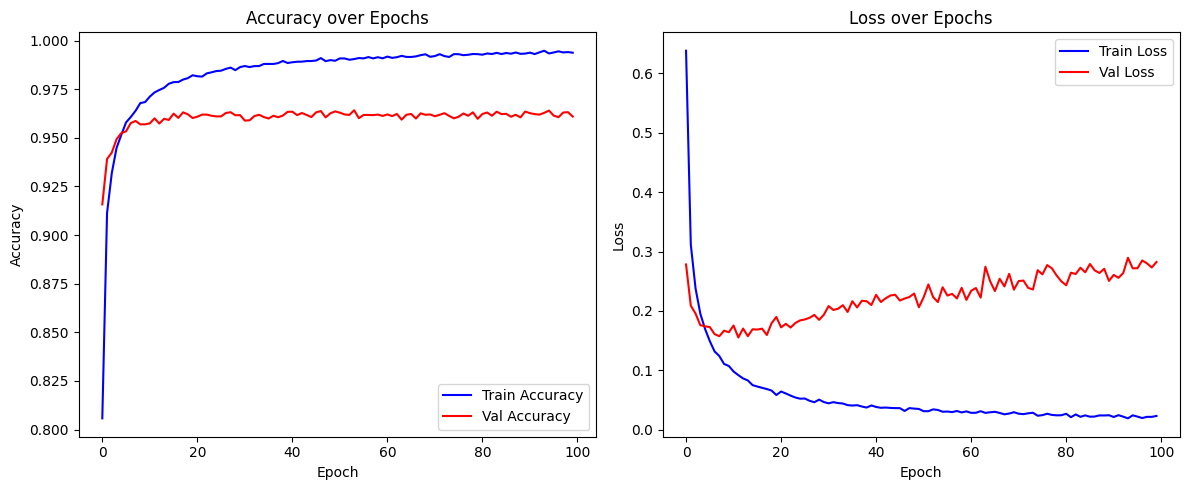

In [25]:
MLP_3H = build_tf_model_3H(256, 64, 32, 0.2, 'adam', 1e-4)

history = MLP_3H.fit(train_images_norm, train_labels, epochs= 100, validation_data=(validation_images_norm, validation_labels))

# Plot losses and accuracy
plot_training_results(history)

313/313 - 0s - 795us/step - accuracy: 0.8480 - loss: 0.5043 - precision: 0.8963 - recall: 0.8149
Test accuracy: 0.8480
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step


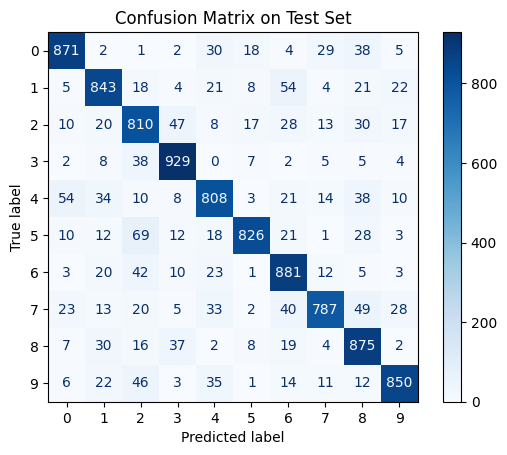

In [23]:
# Evaluate on test set
test_labels = pd.get_dummies(test_labels, dtype= int).to_numpy()
test_loss, test_acc, _, _ = MLP_3H.evaluate(test_images_norm, test_labels, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")

test_labels = np.argmax(test_labels, axis=1)

# Predict classes on test set
y_pred_prob = MLP_3H.predict(test_images_norm)
y_pred = np.argmax(y_pred_prob, axis=1)

# Create confusion matrix
cm = metrics.confusion_matrix(test_labels, y_pred)

# Plot confusion matrix
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Test Set")
plt.show()

In [120]:
# Flatten each image to be 28*28x1 instead of 28x28
train_images_norm = train_images_norm.reshape(train_images_norm.shape[0], -1)
validation_images_norm = validation_images_norm.reshape(validation_images_norm.shape[0], -1)


mlp_1HL_12Discriminants = MLP_1H(input_size=train_images_norm.shape[1], hidden_size=12, output_size=10, learning_rate=1e-7)
mlp_1HL_12Discriminants.train(train_images_norm, train_labels, epochs=1000, X_val= validation_images_norm, y_val= validation_labels)

# Plot losses
plt.plot([i for i in range(mlp_1HL_12Discriminants.epochs)], mlp_1HL_12Discriminants.losses, label='Training Loss')
plt.plot([i for i in range(mlp_1HL_12Discriminants.epochs)], mlp_1HL_12Discriminants.val_losses, label='Validation Loss')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.show()

ValueError: operands could not be broadcast together with shapes (10,48000) (48000,10) 

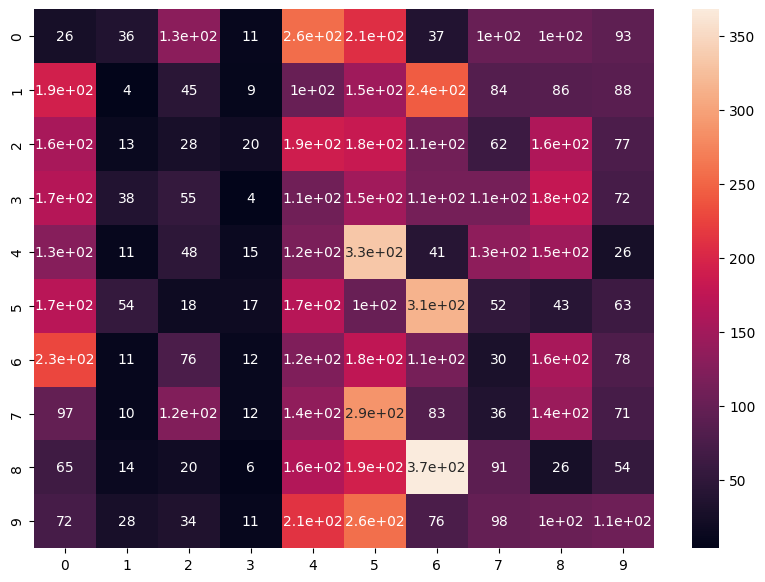

In [114]:
from sklearn import metrics
import seaborn as sn

test_images_norm = test_images_norm.reshape(test_images_norm.shape[0], -1)

predictions = mlp_1HL_12Discriminants.forward_pass(test_images_norm)
y_test_predicted = list()

for row in predictions:
    y_test_predicted.append((np.argmax(row)))

confusion_matrix = metrics.confusion_matrix(test_labels, y_test_predicted)

df_cfm = pd.DataFrame(confusion_matrix, index= np.unique(test_labels), columns=np.unique(test_labels))
plt.figure(figsize=(10, 7))
cfm_plot = sn.heatmap(df_cfm, annot=df_cfm)

In [115]:
metrics.accuracy_score(test_labels, y_test_predicted)

0.0564